In [1]:
import theano.tensor as tt
import pysal as ps
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import ops
import distributions as spdist
import scipy.sparse as spar
import scipy.sparse.linalg as spla
import pymc3 as mc
%matplotlib inline

In [2]:
df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df.query('STATE_NAME in ("Texas", "Oklahoma", "Arkansas", "Louisiana")')

In [3]:
df.head()

,FIPSNO,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
288,40035,Craig,Oklahoma,40,035,40035,40,35,1,4.089227,...,3.424560,0.359287,0.416758,0.358676,0.380774,11.921235,8.7,9.077454,10.746190,<pysal.cg.shapes.Polygon object at 0x7f9d72f21...
289,40105,Nowata,Oklahoma,40,105,40105,40,105,1,9.218289,...,3.642914,0.300158,0.410097,0.348434,0.378781,9.818679,7.9,6.892308,10.108052,<pysal.cg.shapes.Polygon object at 0x7f9d72f21...
290,40115,Ottawa,Oklahoma,40,115,40115,40,115,1,5.889073,...,0.615163,0.318218,0.382949,0.361050,0.385546,12.741722,10.4,11.102620,12.518889,<pysal.cg.shapes.Polygon object at 0x7f9d72f21...
291,40113,Osage,Oklahoma,40,113,40113,40,113,1,3.082519,...,10.109257,0.284325,0.376536,0.359410,0.381143,10.104046,7.6,8.170547,12.124602,<pysal.cg.shapes.Polygon object at 0x7f9d72f21...
292,40071,Kay,Oklahoma,40,071,40071,40,71,1,1.959171,...,1.781255,0.262299,0.367160,0.355859,0.376317,9.218101,7.3,8.869334,9.808418,<pysal.cg.shapes.Polygon object at 0x7f9d72f21...


In [4]:
df = df[df.HR90 > 0]

In [5]:
Y = np.log(df[['HR90']].values)
X = df[['GI89', 'FH90']].values
N,P = X.shape

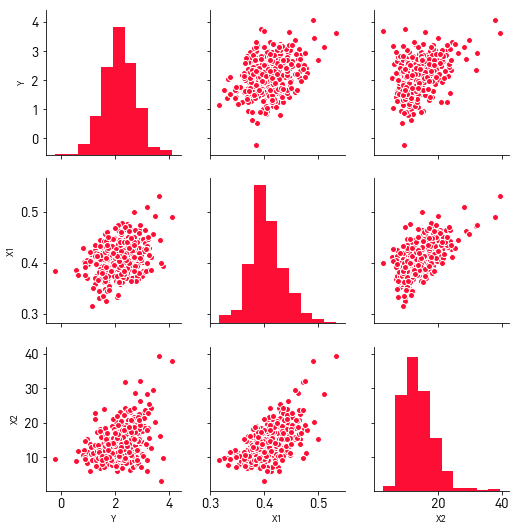

In [6]:
sns.pairplot(pd.DataFrame([Y.flatten(),*X.T], index = ['Y', 'X1', 'X2']).T)

In [7]:
W = ps.weights.Queen.from_dataframe(df)

In [8]:
W.transform = 'r'

In [9]:
Yknown = 4 + X.dot(np.asarray([[-2], [4]]))

In [10]:
Yknown_e = Yknown + np.linalg.solve((np.eye(W.n) - .45 * W.sparse.toarray()), 
                                    np.random.normal(0,1,size=(W.n,1)))
Yknown_l = np.linalg.solve((np.eye(W.n) - .45 * W.sparse.toarray()), Yknown + np.random.normal(0,1,size=(W.n,1)))

In [11]:
with mc.Model() as SE:
    a = mc.Normal('a', 0,sd=10, testval=0)
    beta = mc.Normal('beta', 0,sd=10, shape=P)
        
    rho = mc.Uniform('rho', lower=-.99, upper=.99, testval=0)
    
    mu = a + tt.dot(X, beta)
    
    outcome = spdist.SAR_Error('outcome', mu=mu, scale=1, rho=rho, method='Ord',
                               W=W, observed=Yknown_e.flatten(), shape=N)

In [12]:
with SE:
    start = mc.find_MAP()

         Current function value: 478.456594
         Iterations: 33
         Function evaluations: 149
         Gradient evaluations: 137


In [13]:
#with SE:
#    trace = mc.sample(2000) #ADVI initialization is fast, NUTS sample is *very* slow
with SE:
    trace = mc.sample(2000, step=mc.Metropolis(), start=start)

100%|██████████| 2000/2000 [01:36<00:00, 20.72it/s]    | 2/2000 [00:00<01:56, 17.08it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01a3008630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f01a2f7d048>]], dtype=object)

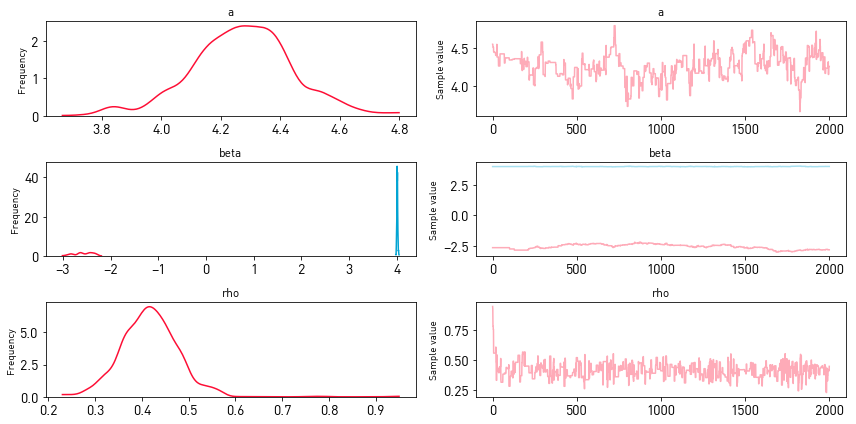

In [14]:
mc.traceplot(trace)

In [15]:
with mc.Model() as SAR_L:
    a = mc.Normal('a', 0,sd=10, testval=0)
    beta = mc.Normal('beta', 0,sd=10, shape=P)
        
    rho = mc.Uniform('rho', lower=-.99, upper=.99, testval=0)
    
    mu = a + tt.dot(X, beta)
    
    outcome = spdist.SAR_Lag('outcome', mu=mu, scale=1, rho=rho, method='Ord',
                               W=W, observed=Yknown_l.flatten(), shape=N)

         Current function value: 429.143681
         Iterations: 21
         Function evaluations: 93
         Gradient evaluations: 81


100%|██████████| 2000/2000 [00:10<00:00, 195.25it/s]   | 18/2000 [00:00<00:11, 177.35it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0193d953c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f019395aac8>]], dtype=object)

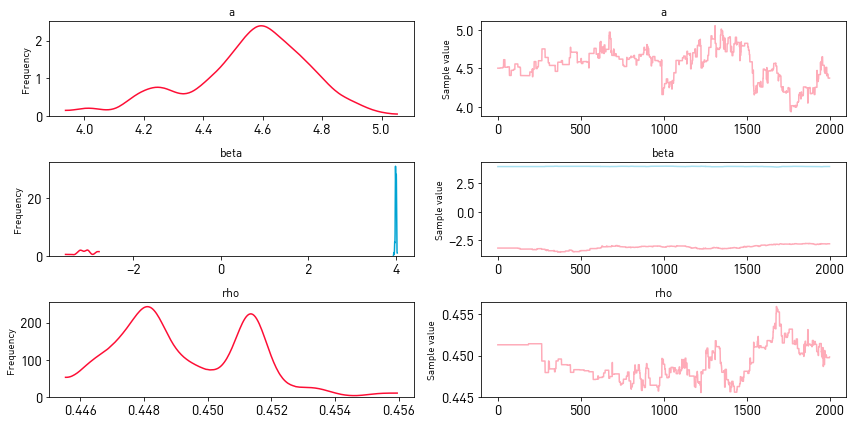

In [16]:
with SAR_L:
    start = mc.find_MAP()
    trace = mc.sample(2000, step=mc.Metropolis(), start=start)
mc.traceplot(trace)

In [11]:
SFEs = pd.get_dummies(df.STATE_NAME).values
Yknown_eSFE = Yknown_e + SFEs.dot(np.array([[10],[2],[4],[-5]]))

In [12]:
Yknown_SFE = Yknown + SFEs.dot(np.array([[10],[2],[4],[-5]])) + np.random.normal(0,1,size=(N,1))

In [13]:
_,J= SFEs.shape

In [ ]:
with mc.Model() as SE_VI:
    const = mc.Normal('const', 0, sd=10)
    
    a = mc.Normal('a', 0, sd=10, shape=J)
    
    beta = mc.Normal('beta', 0,sd=10, shape=P)
    
    sigma = mc.HalfCauchy('sigma', 5)
        
    rho = mc.Uniform('rho', lower=-.99, upper=.99, testval=0)
    
    mu = const + tt.dot(SFEs, a) + tt.dot(X, beta)
    
    outcome = spdist.SAR_Error('outcome', mu=mu, scale=sigma, rho=rho, method='Ord',
                               W=W, observed=Yknown_eSFE.flatten(), shape=N)
    #outcome = mc.Normal('outcome', mu=mu, sd=sigma, observed=Yknown_SFE.flatten())#

         Current function value: 474.734196
         Iterations: 12
         Function evaluations: 116
         Gradient evaluations: 104



100%|██████████| 20000/20000 [26:44<00:00, 12.46it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d57e55dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9d54b6eeb8>]], dtype=object)

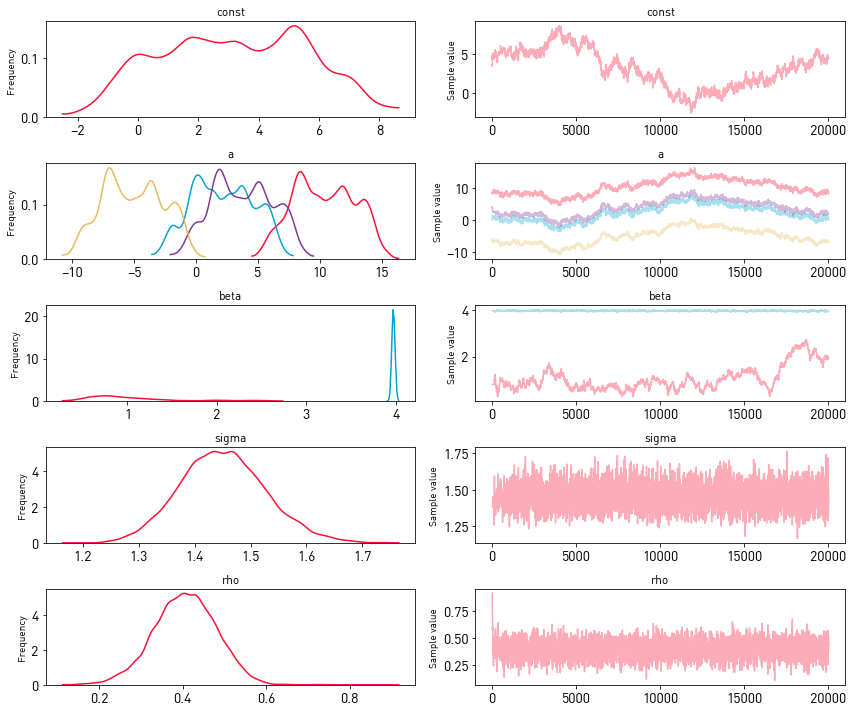

In [18]:
with SE_VI:
    start = mc.find_MAP()
    trace = mc.sample(20000, step=mc.Metropolis(), start=start)
#with SE_VI:
#    trace = mc.sample(2000) #ADVI is fast, NUTS hangs immediately
mc.traceplot(trace)